_Last Updated: 06/14/2021_

In [1]:
import gurobipy as gp
from gurobipy import GRB, abs_
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import pandas as pd
%matplotlib inline

In [2]:
x = np.array([[0,0],[0,1], [1,0], [1,1]])
y = np.array([0,1,1,0])

### Langrangian Dual Subproblems

In [3]:
N = y.shape[0]
D = x[0].shape[0] # dimension of data
K = 2 # Number of units in each hidden layer
L = 3 # Number of hidden layers

w_ub, w_lb, b_ub, b_lb = [1,-1,1,-1]
epsilon = 0.01

In [4]:
def zeta_0(λ):

    # Create a new model
    m = gp.Model("0-th layer")
    
    # Create variables
    
    alpha = {}
    beta = {}
    h = {}

    for k in range(K):
        beta[(k,0)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,0)))
        for d in range(D):
            alpha[(d,k,0)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((d,k,0)))
            
        for n in range(N):
            h[(n,k,0)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,0)))
            
    # Set objective

    m.setObjective( 
        sum( sum( sum( -λ[(n,k_prime,k,1)]*h[(n,k_prime,0)] 
                      for k in range(K)) for k_prime in range(K)) for n in range(N)), GRB.MINIMIZE)
        
   # Add constraints 
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        <= -epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="C1 Binary Neuron "+str((n,k,0)))
            
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        >= epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="C2 Binary Neuron "+str((n,k,0)))
            
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [5]:
def zeta_l(layer, λ):
    
    # Create a new model
    m = gp.Model("l-th layer")
    
    l = layer # layer to be solved for
    
    # Create variables

    alpha = {}
    beta = {}
    z = {}
    h = {}
    g = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l)))
                g[(n,k_prime,k,l)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,k,l)))
                
            h[(n,k,l)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,l)))
        
        beta[(k,l)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,l)))
        
    # Set objective
        
    m.setObjective( sum( sum( sum( λ[(n,k_prime,k,l)]*g[(n,k_prime,k,l)] 
                                 - λ[(n,k_prime,k,l+1)]*h[(n,k_prime,l)] 
                                 for k in range(K)) for k_prime in range(K)) for n in range(N)) ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        <= -epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="C1 Binary Neuron "+str((n,k,l))) 

            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="C2 Binary Neuron "+str((n,k,l)))
            
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,l)] <= alpha[(k_prime,k,l)], name="Explicit z-alpha Upper Bound "+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] - alpha[(k_prime,k,l)] >= (-w_ub)*(1-g[(n,k_prime,k,l)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*g[(n,k_prime,k,l)], name = "z-g Upper Bound"+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*g[(n,k_prime,k,l)], name = "z-g Lower Bound"+str((n,k_prime,k,l)))
                
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [6]:
def zeta_penultimate_L(λ):
    
    # Create a new model
    m = gp.Model("(L-1)st layer")
    
    # Create variables

    alpha = {}
    beta = {}
    z = {}
    h = {}
    g = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,L-1)))
                g[(n,k_prime,k,L-1)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,k,L-1)))
                
            h[(n,k,L-1)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,L-1)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,L-1)))
        
        beta[(k,L-1)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,L-1)))
        
    # Set objective
        
    m.setObjective( sum( sum( sum( λ[(n,k_prime,k,L-1)]*g[(n,k_prime,k,L-1)] for k in range(K))
                             - λ[(n,k_prime,0,L)]*h[(n,k_prime,L-1)] 
                             for k_prime in range(K)) for n in range(N))
                   ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        <= -epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,L-1)], name="C1 Binary Neuron "+str((n,k,L-1))) 

            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,L-1)]), name="C2 Binary Neuron "+str((n,k,L-1)))
            
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,L-1)] <= alpha[(k_prime,k,L-1)], name="Explicit z-alpha Upper Bound "+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] - alpha[(k_prime,k,L-1)] >= (-w_ub)*(1-g[(n,k_prime,k,L-1)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] <= (w_ub)*g[(n,k_prime,k,L-1)], name = "z-g Upper Bound"+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] >= (w_lb)*g[(n,k_prime,k,L-1)], name = "z-g Lower Bound"+str((n,k_prime,k,L-1)))
                
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [7]:
def zeta_L(λ):
    
    # Create a new model
    m = gp.Model("L-th layer")
        
    # Create variables
    
    alpha = {}
    beta = {}
    z = {}
    g = {}
    y_hat = {}
    loss = {}
    
    for n in range(N):
        
        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss[n] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="loss"+str(n))
        
        for k_prime in range(K):
            z[(n,k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="z"+str((n,k_prime,0,L)))
            g[(n,k_prime,0,L)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,0,L)))
            
    beta[(0,L)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((0,L)))
    
    for k_prime in range(K):
        alpha[(k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,0,L)))
            
    # Set objective
    
    m.setObjective( sum( loss[n] 
                        + sum( λ[(n,k_prime,0,L)]*g[(n,k_prime,0,L)] for k_prime in range(K))
                       for n in range(N)) ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    <= -epsilon + ((K*w_ub)+b_ub + epsilon)*y_hat[n], name="C1 Binary Neuron "+str((n,0,L))) 

        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    >= epsilon + ((K*w_lb)+b_lb - epsilon)*(1-y_hat[n]), name="C2 Binary Neuron "+str((n,0,L)))
        
        m.addConstr(loss[n] >= y[n] - y_hat[n], name = "C1 Loss Function"+str(n))
        m.addConstr(loss[n] >= -y[n] + y_hat[n], name = "C2 Loss Function"+str(n))
        
        for k_prime in range(K):
            m.addConstr(z[(n,k_prime,0,L)] <= alpha[(k_prime,0,L)], name="Explicit z-alpha Bound "+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] - alpha[(k_prime,0,L)] >= (-w_ub)*(1-g[(n,k_prime,0,L)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] <= (w_ub)*g[(n,k_prime,0,L)], name = "z-g Upper Bound"+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] >= (w_lb)*g[(n,k_prime,0,L)], name = "z-g Lower Bound"+str((n,k_prime,0,L)))
                            
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


### Solving the dual with the Subgradient algorithm

In [12]:

# λ_norm_tracker = []
# for i in range(100):

    ## initialize langrange multiplier

λ = {} 

np.random.seed(6142021)

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
                λ[(n,k_prime,k,l)] = np.random.uniform(low=-100, high=100)
        λ[(n,k_prime,0,L)] = np.random.uniform(low=-100, high=100)

λ_array = list(λ.values())        

output = {} # dictionary of outputs

    ## Solve subproblems and find the dual objective

dual_obj = zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ) 

    ## Find the subgradient vector at λ

s = {}

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
                s[(n,k_prime,k,l)] = output['g'+str((n,k_prime,k,l))] - output['h'+str((n,k_prime,l-1))]
        s[(n,k_prime,0,L)] = output['g'+str((n,k_prime,0,L))] - output['h'+str((n,k_prime,L-1))]

s_array = np.array(list(s.values()))

    ## Simple Stepsize

# gamma = 1

    ## Adaptive Stepsize

mu_naught = 2
mu = mu_naught

Z_best = 0 # Lower bound on primal

gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)

    ## Track the projected subgradinet

indicator = []

for i in range(len(λ_array)):
    if (λ_array[i] + gamma*s_array[i]) > 0:
        indicator.append(1)
    else:
        indicator.append(0)

indicator = np.array(indicator)
projected_s = indicator.T*s_array

#     if (dual_obj >= -1e-6) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
#         print("The dual objective roughly optimal")
#     else:
#         print("Proceed with the subgradient algorithm")

subgradient_tracker = [np.linalg.norm(s_array)]
dual_obj_tracker = [dual_obj]
gamma_tracker = [gamma]
projected_s_tracker = [np.linalg.norm(projected_s)]
mu_tracker = [mu]

adapt_param_factor = 2/3 # try 1/4 and 2/3

T = 0 # Number of times Z_{D} did not increase


for t in range(1,1000): 

    if t%100 == 0:
        print("Iteration count:", t)

        ## Update λ

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
                    λ[(n,k_prime,k,l)] = λ[(n,k_prime,k,l)] + gamma*s[(n,k_prime,k,l)]
            λ[(n,k_prime,0,L)] = λ[(n,k_prime,0,L)] + gamma*s[(n,k_prime,0,L)]

    λ_array = np.array(list(λ.values()))

        ## Solve subproblems and find the dual objective

    dual_obj = zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ) 

    dual_obj_tracker.append(dual_obj)

        ## Find the subgradient vector at λ

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
                    s[(n,k_prime,k,l)] = output['g'+str((n,k_prime,k,l))] - output['h'+str((n,k_prime,l-1))]
            s[(n,k_prime,0,L)] = output['g'+str((n,k_prime,0,L))] - output['h'+str((n,k_prime,L-1))]

    s_array = np.array(list(s.values()))
    subgradient_tracker.append(np.linalg.norm(s_array))

        ## Simple step-size

#     gamma = 1/np.sqrt(t) 

        ## Adaptive Polyak Stepsize

    if dual_obj > Z_best:
        Z_best = dual_obj

    if not (dual_obj > dual_obj_tracker[-2]):
        T += 1
    else:
        T = 0

    if T >= 2: # scaling mu if Z_{D} did not increase in the last 2 iterations
        mu = adapt_param_factor*mu

    mu_tracker.append(mu)

    gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)
    gamma_tracker.append(gamma)

        ## Track norm of projected subgradinet

    indicator = []

    for i in range(len(λ_array)):
        if (λ_array[i] + gamma*s_array[i]) < 0:
            indicator.append(0)
        else:
            indicator.append(1)

    indicator = np.array(indicator)
    projected_s = indicator.T*s_array

    projected_s_tracker.append(np.linalg.norm(projected_s))

    if (dual_obj >= -1e-5) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
        break

#         The lower bound on the primal might not always be 0, but should be??

assert all((x <= 1e-8 and x >= -1e-8) for x in λ_array*s_array), "Complementary Slackness Conditions are not upheld"

#     λ_norm_tracker.append(np.linalg.norm(λ_array))
    
# λ_norm_tracker


AssertionError: Complementary Slackness Conditions are not upheld

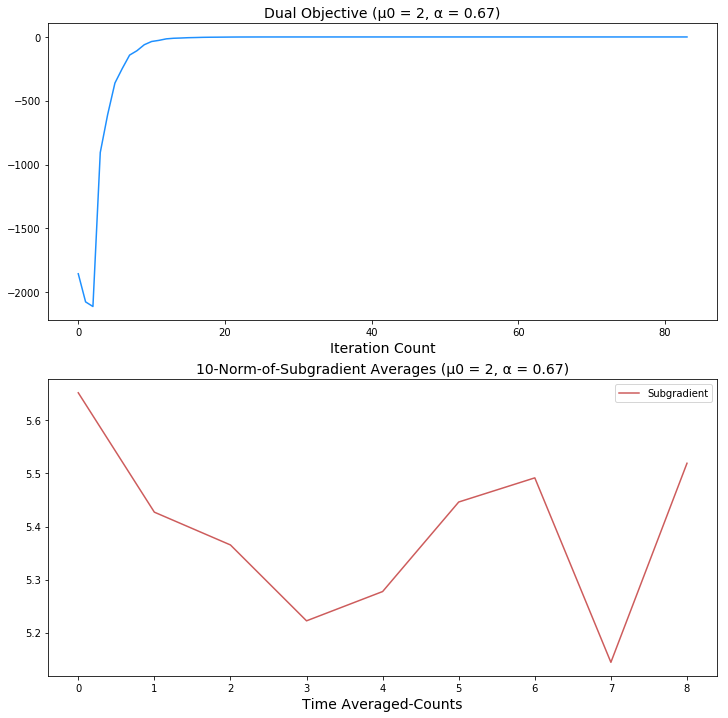

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 12)

subgrad_y1 = [np.mean(subgradient_tracker[i:i+10]) for i in range(0,len(subgradient_tracker),10)]
# subgrad_y2 = [np.mean(projected_s_tracker[i:i+10]) for i in range(0,len(projected_s_tracker),10)]

ax1.plot([x for x in range(t+1)], dual_obj_tracker, c="dodgerblue")
ax2.plot([x for x in range(len(subgrad_y1))], subgrad_y1, c="indianred")
# ax2.plot([x for x in range(len(projected_s_tracker))], projected_s_tracker, c="dodgerblue")

ax1.set_title("Dual Objective (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)
ax2.set_title("10-Norm-of-Subgradient Averages (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)

ax2.legend(["Subgradient", "Projected Subgradient"])

ax1.set_xlabel('Iteration Count', fontsize=14)
ax2.set_xlabel('Time Averaged-Counts', fontsize=14)

# filename = 'mu0={} alpha={}.png'.format(np.round(mu_naught,2), np.round(adapt_param_factor,2))
# plt.savefig("Subgradient Plots/"+filename)

None

In [51]:
# z-g-h-λ Table Maker

index_list = []
z_list = []
g_list = []
h_list = []
λ_list = []

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
                index_list.append((n,k_prime,k,l))
                z_list.append(output['z'+str((n,k_prime,k,l))])
                g_list.append(output['g'+str((n,k_prime,k,l))])
                h_list.append(output['h'+str((n,k_prime,l-1))])
                λ_list.append(λ[(n,k_prime,k,l)])
                
        index_list.append((n,k_prime,0,L))
        z_list.append(output['z'+str((n,k_prime,0,L))])
        g_list.append(output['g'+str((n,k_prime,0,L))])
        h_list.append(output['h'+str((n,k_prime,L-1))])
        λ_list.append(λ[(n,k_prime,0,L)])
        
z_g_h_λ_dict = {"(n,k\',k,l)":index_list, "z-values": z_list, "g-values": g_list, "h-values": h_list, "λ":λ_list}                
df = pd.DataFrame(z_g_h_λ_dict)
# df.to_csv("z-g-h-λ Table.csv") 
df
                

,"(n,k',k,l)",z-values,g-values,h-values,λ
0,"(0, 0, 0, 1)",0.00,-0.0,1.0,6.109707e-08
1,"(0, 0, 0, 2)",0.00,-0.0,1.0,3.043422e-07
2,"(0, 0, 1, 1)",0.00,0.0,1.0,2.024140e-07
3,"(0, 0, 1, 2)",0.00,0.0,1.0,-2.683108e-07
4,"(0, 0, 0, 3)",0.00,1.0,1.0,-1.011330e-07
5,"(0, 1, 0, 1)",0.00,-0.0,1.0,7.895285e-08
6,"(0, 1, 0, 2)",0.02,1.0,0.0,-3.152387e-07
7,"(0, 1, 1, 1)",0.00,0.0,1.0,5.006347e-08
8,"(0, 1, 1, 2)",0.00,0.0,0.0,-2.748671e-07
9,"(0, 1, 0, 3)",0.00,-0.0,0.0,-1.975366e-08


### Primal Feasible Solution

In [11]:
h = {} # tracks output of units

correct_pred = 0

for n in range(N):
    for k in range(K):
        h[(k,0)] = sum(output["alpha"+str((d,k,0))]*x[n,d] for d in range(D)) + output["beta"+str((k,0))]
#         print("Pre-activated  h[",(n,k,0),"] = ", h[(k,0)])

        if h[(k,0)] <= 0:
            h[(k,0)] = 0
        else:
            h[(k,0)] = 1
#         print("h[",(n,k,0),"] = ", h[(k,0)])

    for l in range(1,L):
        for k in range(K):
            h[(k,l)] = sum(output["alpha"+str((k_prime,k,l))]*h[(k_prime,l-1)] for k_prime in range(K)) + output["beta"+str((k,l))]
#             print("Pre-activated h[",(n,k,l),"] = ", h[(k,l)])

            if h[(k,l)] <= 0:
                h[(k,l)] = 0
            else:
                h[(k,l)] = 1
#             print("h[",(n,k,l),"] = ", h[(k,l)])

    y_hat = sum(output["alpha"+str((k_prime,0,L))]*h[(k,L-1)] for k in range(K)) + output["beta"+str((0,L))]
    if y_hat <= 0:
        y_hat = 0
    else:
        y_hat = 1

    if y_hat == y[n]:
        correct_pred += 1
    
    print(x[n][0], "XOR", x[n][1], "=", float(y_hat), "Should be ", float(y[n]))

print("\nPrediction Accuracy = ", correct_pred/(n+1)*100, "%")

0 XOR 0 = 1.0 Should be  0.0
0 XOR 1 = 1.0 Should be  1.0
1 XOR 0 = 1.0 Should be  1.0
1 XOR 1 = 1.0 Should be  0.0

Prediction Accuracy =  50.0 %


In [199]:
output

{'beta(0, 0)': -0.01,
 'alpha(0, 0, 0)': -1.0,
 'alpha(1, 0, 0)': 1.0,
 'h(0, 0, 0)': -0.0,
 'h(1, 0, 0)': 1.0,
 'h(2, 0, 0)': -0.0,
 'h(3, 0, 0)': -0.0,
 'beta(1, 0)': -0.01,
 'alpha(0, 1, 0)': 0.01999999999999979,
 'alpha(1, 1, 0)': -1.0,
 'h(0, 1, 0)': -0.0,
 'h(1, 1, 0)': -0.0,
 'h(2, 1, 0)': 1.0,
 'h(3, 1, 0)': -0.0,
 'z(0, 0, 0, 1)': -1.0,
 'g(0, 0, 0, 1)': 1.0,
 'z(0, 1, 0, 1)': 1.0,
 'g(0, 1, 0, 1)': 1.0,
 'h(0, 0, 1)': 1.0,
 'z(1, 0, 0, 1)': -1.0,
 'g(1, 0, 0, 1)': 1.0,
 'z(1, 1, 0, 1)': 1.0,
 'g(1, 1, 0, 1)': 1.0,
 'h(1, 0, 1)': 1.0,
 'z(2, 0, 0, 1)': -1.0,
 'g(2, 0, 0, 1)': 1.0,
 'z(2, 1, 0, 1)': 1.0,
 'g(2, 1, 0, 1)': 1.0,
 'h(2, 0, 1)': 1.0,
 'z(3, 0, 0, 1)': -1.0,
 'g(3, 0, 0, 1)': 1.0,
 'z(3, 1, 0, 1)': 0.0,
 'g(3, 1, 0, 1)': 0.0,
 'h(3, 0, 1)': 0.0,
 'alpha(0, 0, 1)': -1.0,
 'alpha(1, 0, 1)': 1.0,
 'beta(0, 1)': 0.99,
 'z(0, 0, 1, 1)': 1.0,
 'g(0, 0, 1, 1)': 1.0,
 'z(0, 1, 1, 1)': 1.0,
 'g(0, 1, 1, 1)': 1.0,
 'h(0, 1, 1)': 1.0,
 'z(1, 0, 1, 1)': 0.0,
 'g(1, 0, 1, 1)': -

We want $ g_{n,k\prime,k,l} = h_{n,k\prime,l-1} $

However, see that $ g_{1,0,0,3} = 1 \neq h_{1,0,2} = 0 $

In [52]:
output['g'+str((1,0,0,3))]

1.0

In [53]:
output['h'+str((1,0,2))]

0.0